# CNN Exercise 2: The Kaggle Cats and dogs challenge

## Introduction

In this exercise we will try to solve an actual challenge, namely the Kaggle Cats and Dogs challenge https://www.kaggle.com/c/dogs-vs-cats. The challenge is to determine whether it is a cat or a dog that is in the image. As we know now, this is not straightforward using "classical" machine learning approaches. However, convolutional neural networks provide improved performance coupled with spatial invariance, which solves major previous obstacles. Several of the submitted solutions can be investigated here: https://www.kaggle.com/c/dogs-vs-cats/kernels. For example, there is one with a good explanation of CNNs, if you need a recap, here: https://www.kaggle.com/ruchibahl18/cats-vs-dogs-basic-cnn-tutorial.

One word of advise for this exercise is to be patient. Some of the models will take quite a while to train, unless you are using GPU acceleration. It is suggested that you implement the code whlie using a very limited number of epochs. Once all the code runs, set the epochs to, e.g., 100, and let your computer train overnight. This is similar to how working with deep learning often is. Do note, however, that the training procedure can be quite noisy, so even though you let it run for 5 epochs, you might not see much improvement. Try letting it train for 20-30 epochs and see if you witness improvements.

If you have an NVidia GPU, you can significantly reduce the training time by installing TensorFlow with GPU support. It can be a hassle though, and if you choose to do so, be absolutely sure that the version of TensorFlow works with the versions of CUDA and CuDNN you install (rqeuired libraries to support GPU acceleration). An alternative which might work is Google Colab (https://colab.research.google.com/notebooks/welcome.ipynb). I have not yet tried it out, so I do not know how much of a help it is, but you can take a look. They offer GPU acceleration for free.

You need to install split-folders (https://pypi.org/project/split-folders/)

In [1]:
# Scientific and vector computation for python
import numpy as np
np.random.seed(42)  # Set the global random seed to make reproducible experiments (scikit-learn also use this)

# Used for manipulating directory paths
import os

# Library to handle images
from PIL import Image, ImageOps

# Used to delete directories
import shutil

# Unzip files
import zipfile

# Split a directory of images into two directories containing train and test images
import split_folders

# Deep learning framework
from keras.models import Sequential  # Create models sequentially
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D  # Relevant layers
from keras.optimizers import Adam  # Optimizer for gradient descent
from keras.backend import clear_session  # Delete previous models
from keras.preprocessing.image import ImageDataGenerator  # To feed the model with images during training

# Set the global random seed for TensorFlow to make reproducible experiments
from tensorflow import set_random_seed
set_random_seed(42)

# Ignore warning for corrupt EXIF data in the images
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

# Plotting library
import matplotlib.pyplot as plt  
%matplotlib inline

Using TensorFlow backend.


## 1 Get and preprocess dataset

The dataset can be downloaded here (put it in the same directory as the jupyter notebook): https://www.microsoft.com/en-us/download/details.aspx?id=54765. Then execute the code below. 

In [3]:
# Check if data has already been processed
if not os.path.exists(os.path.join('Data', 'kagglecatsanddogs_3367a', 'processed')):
    print("Processing data.")
    
    # Delete any previous 'kagglecatsanddogs' datasets, if they should be present
    try:
        shutil.rmtree(os.path.join('Data', 'kagglecatsanddogs_3367a'))
    except:
        pass

    # Unzip images
    with zipfile.ZipFile("kagglecatsanddogs_3367a.zip","r") as zip_ref:
    # zip_ref.extractall(os.path.join('Data', 'kagglecatsanddogs', 'raw'))
        zip_ref.extractall(os.path.join('Data'))

    # Remove two corrupt images
    os.remove(os.path.join('Data', 'kagglecatsanddogs_3367a', 'PetImages', 'Cat', '666.jpg'))
    os.remove(os.path.join('Data', 'kagglecatsanddogs_3367a', 'PetImages', 'Dog', '11702.jpg'))

    # Split dataset into train and test set
    split_folders.ratio(os.path.join('Data', 'kagglecatsanddogs_3367a', 'PetImages'), 
                        output=os.path.join('Data', 'kagglecatsanddogs_3367a', 'processed'), 
                        seed=42, 
                        ratio=(.7, 0, .3))
else:
    print("It seems like the data has already been processed.")

Processing data.


## 2 Create your own CNN in Keras to classify cats/dogs

First let us set some hyperparameters. One important note regarding epochs in this exercise is that it is implemented such that an epoch only goes through 1/50 of the available data. This is opposed to the general definition of an epoch, which is defined by training through the entire dataset once. The reason for the difference here is because we want Keras go through test samples and save the accuracies and loss more often than only once per "actual" epoch.

In [4]:
# Dataset details
train_samples = 17498
test_samples = 7500

# Hyperparameters
img_width, img_height = 128, 128  # Size you want to rescale images to
batch_size = 32
epochs = 5  # In this exercise, 50 epochs corresponds to training on the entire dataset once

In this exercise, we are not loading the data into the computer's RAM, which we have done in all exercises until now. This is to demonstrate how we could facilitate training of deep learning models on hundreds of gigabytes of data which have to be stored on the SSD. We will use the ImageDataGenerator class, which have implemented a method to fetch images from directories on the SSD. If you are not familiar with generators in Python, then do not worry, as they are not very relevant for this exercise. Just think of them as functions which provide you a new batch of images everytime you call them.

The ImageDataGenerator class also has built-in functionality for performing real-time data augmentation. Data augmentation is the concept of applying transformations to your training data, to make them "appear" as new training data. For instance, if you flip an image of a dog horizontally, the neural network will see it as a new dog, and not recognize that it is simply a flipped version of the initial image. So much for neural networks being highly sophisticated AI machines. Jokes aside, data augmentation is a powerful ally when training deep neural networks, especially if you do not have massive amounts of training data. In this exercise, however, we will not investigate it further.   

What you should note is that in the entirety of this exercise, cats are assigned to class 0 and dogs are assigned to class 1. So if the classifier outputs 0, it means that it is completely confident that there is a cat in the image. Likewise, if it outputs 1, it is completely confident that there is a dog in the image.

Found 17498 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


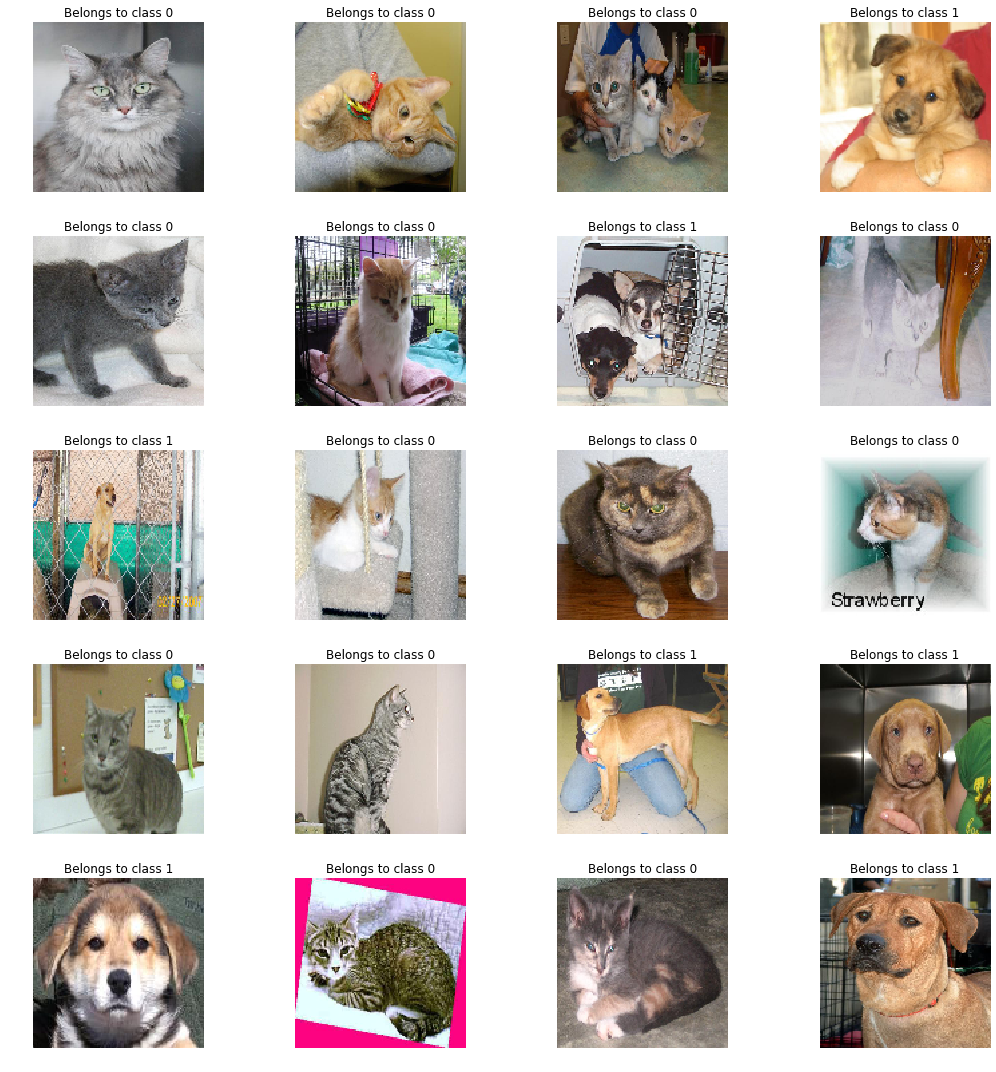

In [5]:
# Use data augmentation during training
datagen = ImageDataGenerator(rescale=1./255)  # Re-scale images to pixel values between 0 and 1


train_generator = datagen.flow_from_directory('Data/kagglecatsanddogs_3367a/processed/train',
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='binary')

test_generator = datagen.flow_from_directory('Data/kagglecatsanddogs_3367a/processed/test',
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             class_mode='binary')

# Plot some examples from the training dataset
plt.figure(figsize=(15, 15))
for X_batch, Y_batch in train_generator:
    for i in range(0, 20):
        plt.subplot(5, 4, i+1)
        image = X_batch[i]
        plt.title("Belongs to class " + str(int(Y_batch[i])))
        plt.axis('off')
        plt.imshow(image)
    break  # Break the for loop after a single batch
plt.tight_layout()
plt.show()

## 3 Define models

### 3.1 Your own CNN from scratch

Try defining a reasonable CNN architecture for the task at hand. Remember that this challenge is to built a binary classifier, so the last layer should be a dense layer with 1 neuron, employing the sigmoid activation function.

In [6]:
clear_session()  # Delete any existing models

# Define model
# ====================== YOUR CODE HERE =======================

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# =============================================================

model.compile(optimizer=Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 60, 64)        256       
__________

Now try training the classifier you just made.

In [7]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_samples/batch_size/50,
                              epochs=epochs,
                              validation_data=test_generator,
                              validation_steps=test_samples/batch_size/50)

model.save("model_Custom.h5")

Epoch 1/5
11/10 [==============================] - 26s 2s/step - loss: 0.9242 - acc: 0.5199 - val_loss: 0.7305 - val_acc: 0.5437
Epoch 2/5
11/10 [==============================] - 19s 2s/step - loss: 0.9299 - acc: 0.4943 - val_loss: 0.7231 - val_acc: 0.5625
Epoch 3/5
11/10 [==============================] - 19s 2s/step - loss: 0.8641 - acc: 0.5426 - val_loss: 0.7345 - val_acc: 0.4875
Epoch 4/5
11/10 [==============================] - 19s 2s/step - loss: 0.8644 - acc: 0.5227 - val_loss: 0.6699 - val_acc: 0.6250
Epoch 5/5
11/10 [==============================] - 19s 2s/step - loss: 0.7978 - acc: 0.5767 - val_loss: 0.6910 - val_acc: 0.5687


Let us plot the training history.

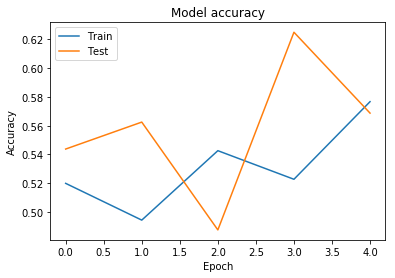

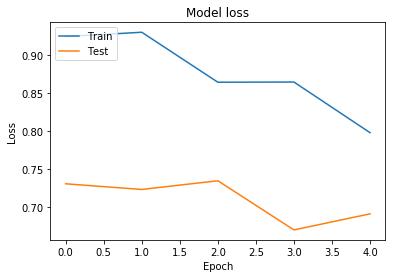

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

As you probably realized, this training procedure can take a long time! Once you feel ready to let your computer train for longer, go back to the beginning of Section 2, where we set our hyperparameters, and increase the number of epochs which you want to train for. You might need to train for hundreds of epoch before the model converges to a good solution.

### 3.2 Use VGG16 pre-trained feature extractor 

Remember that the convolutional layers in a CNN acts as feature extractor, which transforms the input image to an improved data representation for the classifier to function optimally. So instead of training our neural network from scratch, it would make sense that we took a pre-trained feature extractor from another architecture, and then add a neural network classifier on top of it. In the code below, a trained version of the feature extractor from the VGG16 architecture (https://arxiv.org/pdf/1409.1556.pdf) is loaded. It is made trainable, so once you train your entire model, the feature extractor will also be fine-tuned. Your task is now to add a neural network classifier on top of the feature extractor, with two hidden layers, each with 256 neurons, using ReLU activation functions. Remember that the last layer should be a dense layer with 1 neuron employing the sigmoid activation funciton.

In [9]:
from keras.applications.vgg16 import VGG16
clear_session()  # Delete any existing models

model = Sequential()

feature_extractor = VGG16(weights='imagenet',  # Use weights trained on ImageNet
                          include_top=False,  # Do not include the classifier from the model
                          input_shape=(img_width, img_height, 3))

feature_extractor.trainable=True  # Make it trainable, such that it will fine-tune as you train

model.add(feature_extractor) 
model.add(Flatten())
# ====================== YOUR CODE HERE =======================

model.add(Dense(256, activation='relu')) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# =============================================================

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-5), # The model will not converge if a larger learning rate is chosen
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,878,145
Trainable params: 16,878,145
Non-trainable params: 0
________________________________________________________________

Now try training the classifier you just made.

In [10]:
history_vgg16 = model.fit_generator(
                            train_generator,
                            steps_per_epoch=train_samples/batch_size/50,
                            epochs=epochs,
                            validation_data=test_generator,
                            validation_steps=test_samples/batch_size/50)

model.save("model_VGG16.h5")

Epoch 1/5
11/10 [==============================] - 130s 12s/step - loss: 0.7123 - acc: 0.5227 - val_loss: 0.6402 - val_acc: 0.6937
Epoch 2/5
11/10 [==============================] - 115s 10s/step - loss: 0.6923 - acc: 0.5511 - val_loss: 0.5988 - val_acc: 0.7812
Epoch 3/5
11/10 [==============================] - 101s 9s/step - loss: 0.6314 - acc: 0.6449 - val_loss: 0.5803 - val_acc: 0.7750
Epoch 4/5
11/10 [==============================] - 98s 9s/step - loss: 0.5507 - acc: 0.7131 - val_loss: 0.4854 - val_acc: 0.8438
Epoch 5/5
11/10 [==============================] - 100s 9s/step - loss: 0.5013 - acc: 0.7585 - val_loss: 0.4112 - val_acc: 0.8500


Let us plot the training history.

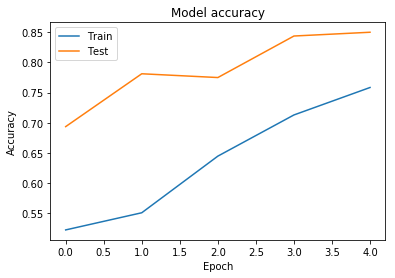

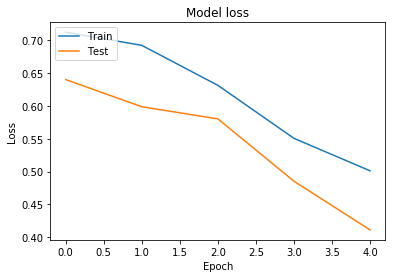

In [11]:
# Plot training & validation accuracy values
plt.plot(history_vgg16.history['acc'])
plt.plot(history_vgg16.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Hopefully, you will se that this approach trains faster. If you would like, you can take a look at the VGG16 feature extractor by running feature_extractor.summary():

In [12]:
feature_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

### 3.3 Use pre-trained MobileNet feature extractor

Similar to before, we will now add a classifier on top of the MobileNet architecture. This architecture is a tremendously fast classifier, made for mobile phones. If you have plenty of time, you can take a look at [TensorFlow Lite](https://www.tensorflow.org/lite), and see how MobileNet can be used to continously [classify what it sees on the back camera of your phone](https://github.com/tensorflow/examples/blob/master/lite/examples/image_classification/android/README.md). 

Your task is, like before, to add a neural network classifier on top of the feature extractor, with two hidden layers, each with 256 neurons, using ReLU activation functions. The last layer should be a dense layer with 1 neuron employing the sigmoid activation funciton.

In [13]:
from keras.applications.mobilenet import MobileNet
clear_session()  # Delete any existing models

model = Sequential()

feature_extractor = MobileNet(weights='imagenet',  # Use weights which have been pre-trained on imagenet
                          include_top=False,  # Do not include the classification part of the model
                          input_shape=(img_width, img_height, 3))

feature_extractor.trainable=True 
model.add(feature_extractor) 
model.add(Flatten())

# ====================== YOUR CODE HERE =======================

model.add(Dense(256, activation='relu')) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# =============================================================

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-5),  # Adam has a quite large default learning rate... 
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 7,489,473
Trainable params: 7,467,585
Non-trainable params: 21,888
_____________________________________________________________

Now try training the classifier you just made.

In [14]:
history_mobilenet = model.fit_generator(train_generator,
                              steps_per_epoch=train_samples/batch_size/50,
                              epochs=epochs,
                              validation_data=test_generator,
                              validation_steps=test_samples/batch_size/50)

model.save("model_MobileNet.h5")

Epoch 1/5
11/10 [==============================] - 40s 4s/step - loss: 0.9514 - acc: 0.6108 - val_loss: 0.6117 - val_acc: 0.6562
Epoch 2/5
11/10 [==============================] - 25s 2s/step - loss: 0.8816 - acc: 0.6193 - val_loss: 0.4229 - val_acc: 0.8063
Epoch 3/5
11/10 [==============================] - 25s 2s/step - loss: 0.6313 - acc: 0.7131 - val_loss: 0.3890 - val_acc: 0.8375
Epoch 4/5
11/10 [==============================] - 24s 2s/step - loss: 0.5925 - acc: 0.7358 - val_loss: 0.3076 - val_acc: 0.8750
Epoch 5/5
11/10 [==============================] - 24s 2s/step - loss: 0.4955 - acc: 0.7869 - val_loss: 0.2191 - val_acc: 0.9250


Let us plot the training history.

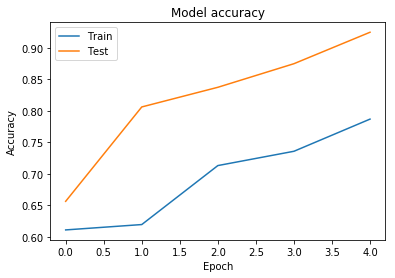

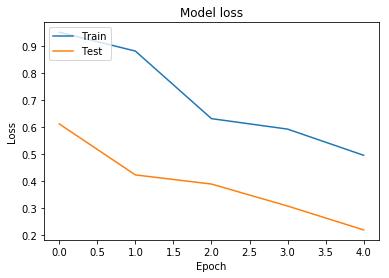

In [16]:
# Plot training & validation accuracy values
plt.plot(history_mobilenet.history['acc'])
plt.plot(history_mobilenet.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 4 Investigate trained models

Try running the code below, using one of your three newly trained models ("Custom", "VGG16", or "MobileNet"). You should now also be able to predict images downloaded from the internet. Try downloading some .jpg images of cats and dogs, and put them in the 'Data/downloaded_samples' directory, and see if your model can recognize whether they are cats or dogs. Remember that a score of 0 corresponds to absolute certainty that it is a cat, and a score of 1 corresponds to absolute certainty that it is a dog.

Loading the MobileNet model.
Predicting images using the test generator:


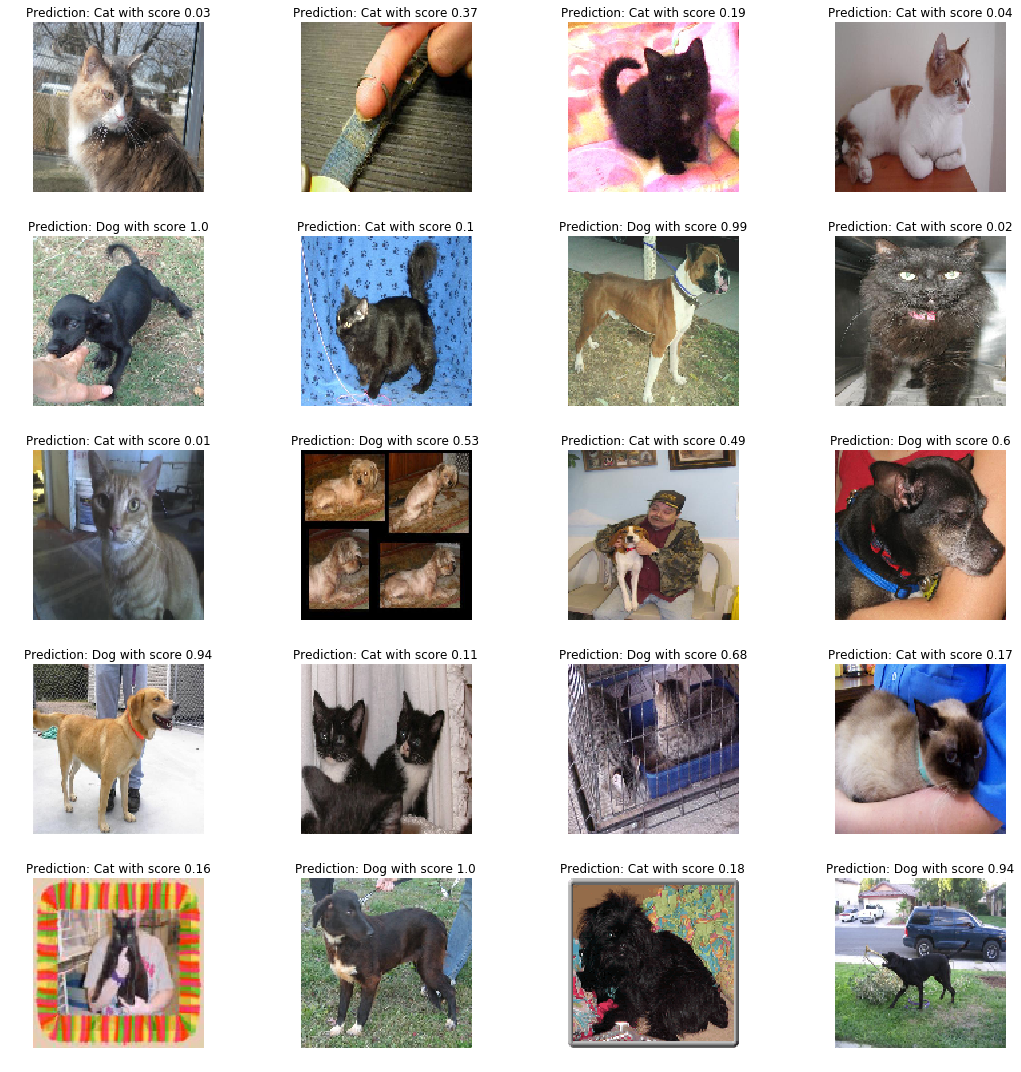

Predicting downloaded images:


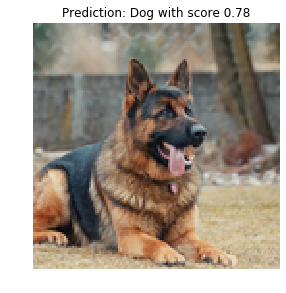

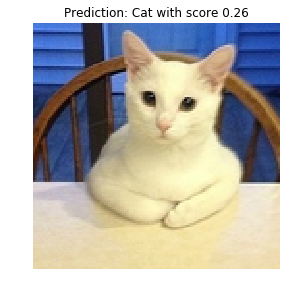

In [17]:
from keras.models import load_model
clear_session()  # Delete any existing models

# ====================== YOUR CODE HERE =======================

# Try changing between your trained models and compare the results
model_name = "MobileNet"  # Either "Custom", "VGG16", or "MobileNet"

# =============================================================

# Load the saved model
print("Loading the " + model_name + " model.")
model = load_model("model_" + model_name + ".h5")

# Load a batch of images using the test_generator and predict them using your model
print("Predicting images using the test generator:")
plt.figure(figsize=(15, 15))
for X_batch, Y_batch in test_generator:
    # Predict cats and dogs in the batch
    predictions = model.predict(X_batch)
    
    # Plot the images and the predictions
    for i in range(0, 20):
        plt.subplot(5, 4, i+1)
        image = X_batch[i]
        plt.axis('off')
        plt.imshow(image)
        if predictions[i] > 0.5:
            prediction = "Dog"
        else:
            prediction = "Cat"
        plt.title("Prediction: " + prediction + " with score " + str(predictions[i][0].round(2)))
    break  # Break the for loop after a single batch
plt.tight_layout()
plt.show()

# Predict downloaded images
filenames = os.listdir(os.path.join('Data', 'downloaded_samples'))  # Find filenames of downloaded images
print("Predicting downloaded images:")
for filename in filenames:    
    # Predict and show image
    image = Image.open(os.path.join('Data', 'downloaded_samples', filename))
    
    # Resize to 128x128 pixels
    image = ImageOps.fit(image, (128, 128), Image.ANTIALIAS)
    
    # Scale to values between 0 and 1
    image_np = np.array(image)/255
    prediction_score = model.predict(image_np.reshape(1, img_width, img_height, 3))
    
    # Plot image and prediction
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    
    if prediction_score > 0.5:
        prediction = "Dog"
    else:
        prediction = "Cat"
    plt.title("Prediction: " + prediction + " with score " + str(prediction_score[0][0].round(2)))
    
    plt.show()




This concludes CNNs. We have skipped one important factor, however, which is the validation dataset. Once you want to do hyperparameter optimization, where you optimize over architecture choices, learning rate, dropout rate etc., you should split your data into training, validation, and test data. The validation data should be used to tune your choices for the model, like we did in this exercise. The test dataset should only be seen by the model in the very end, after hyperparameter optimization, and then be used for evaluation. Several datasets have not made the test data publicly available, and if you contest in a Kaggle competition, you will not get access to the test data. Instead, you submit your model, and they evaluate on data which is has never seen before.